In [ ]:
%env  WORKDIR=/tmp/vault

In [ ]:
%%bash
cat $WORKDIR/VAULT_TOKEN.TXT
cat $WORKDIR/VAULT_ADDR.TXT

In [ ]:
%env VAULT_ADDR=https://vault-primary-europe-southwest1-p5fh.josemerchan-313707.gcp.sbx.hashicorpdemo.com:8200
%env VAULT_TOKEN=hvs.GqTsfXwqgl0bK86WbGIfCBZz

## Enable LDAP Secret Engine

In [ ]:
! vault secrets enable ldap

## Connect to LDAP with username (bindDN) and password

In [ ]:
%%bash
export LDAP_ADDR=$(kubectl get svc -n openldap openldap -o json | jq  -r '.status.loadBalancer.ingress[0].ip')
vault write ldap/config \
    binddn=cn=admin,dc=learn,dc=example \
    bindpass="Passw0rd123!" \
    url=ldap://$LDAP_ADDR:389

In [ ]:
# Se aconseja rotar el password del usuario
vault write -f ldap/rotate-root

## Create a Role (Static Role)

In [ ]:
%%bash
# Automatic Rotation for static account
vault write ldap/static-role/learn \
    dn='cn=serviceaccount,ou=users,dc=learn,dc=example' \
    username='serviceaccount' \
    rotation_period="1h"

### Request credential via CLI

In [ ]:
! vault read ldap/static-cred/learn

### Request credential via API

In [ ]:
! curl -k --header "X-Vault-Token: $VAULT_TOKEN" --request GET --silent $VAULT_ADDR/v1/ldap/static-cred/learn | jq . -r

> #### Credetials are rotated in a lazy manner, ttl gets reduced, once it comes to 0 with the next request credential are rotated

In [ ]:
! vault read ldap/static-cred/learn

### Manual rotation

In [ ]:
! vault write -f ldap/rotate-role/learn

In [ ]:
! vault read ldap/static-cred/learn

## Checking the Static Role account
### Connecting to LDAP with the static role password

In [ ]:
%%bash
LDAP_PASSWORD=$(vault read --format=json ldap/static-cred/learn | jq -r ".data.password")  
LDAP_ADDR=$(kubectl get svc -n openldap openldap -o json | jq  -r '.status.loadBalancer.ingress[0].ip')

ldapsearch -p 389 -h $LDAP_ADDR -b "cn=serviceaccount,ou=users,dc=learn,dc=example" \
    -D 'cn=serviceaccount,ou=users,dc=learn,dc=example' \
    -w $LDAP_PASSWORD

## Dynamic Credentials

In [ ]:
%%bash
cat > ${WORKDIR}/creation.ldif <<EOF
dn: uid={{.Username}},ou=users,dc=learn,dc=example
objectClass: inetOrgPerson
uid: {{.Username}}
cn: {{.Username}}
sn: {{.Username}}
userPassword: {{.Password}}
EOF

In [ ]:
%%bash
cat > ${WORKDIR}/deletion_rollback.ldif <<EOF
dn: uid={{.Username}},ou=users,dc=learn,dc=example
changetype: delete
EOF

In [ ]:
%%bash
# Dynamic Role
vault write ldap/role/dynamic \
     creation_ldif=@${WORKDIR}/creation.ldif \
     deletion_ldif=@${WORKDIR}/deletion_rollback.ldif \
     rollback_ldif=@${WORKDIR}/deletion_rollback.ldif \
     default_ttl=1h

### Request dynamic credentials via CLI

In [ ]:
! vault read ldap/creds/dynamic

In [ ]:
! curl -k --header "X-Vault-Token: $VAULT_TOKEN" --request GET --silent $VAULT_ADDR/v1/ldap/creds/dynamic | jq

### Check leases in Vault

In [ ]:
! vault list sys/leases/lookup/ldap/creds/dynamic

### With an LDAP Browser

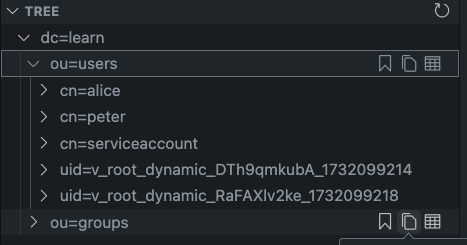

In [ ]:
! kubectl get svc -n openldap openldap -o json | jq  -r '.status.loadBalancer.ingress[0].ip'

### Revoke individual leases

In [ ]:
! vault list sys/leases/lookup/ldap/creds/dynamic

In [ ]:
%%bash
export LEASE=$(vault list -format=json sys/leases/lookup/ldap/creds/dynamic | jq -r .[0])
vault lease revoke ldap/creds/dynamic/$LEASE

In [ ]:
! vault list sys/leases/lookup/ldap/creds/dynamic

### Revoke all

In [ ]:
! vault lease revoke -prefix ldap/creds/dynamic

# Clean UP

In [ ]:
%%bash
vault lease revoke -prefix ldap/creds/dynamic
vault secrets disable ldap